In [1]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
import numpy as np 
from math import exp
from timeit import default_timer as timer

In [2]:
with_measures = 0.005
without_measures = 0.9
time_measures_implemented = 27
# will be using 10, 1, 0.1 
steepness_of_change = 10 # smaller means that the change to 0.005 is slower

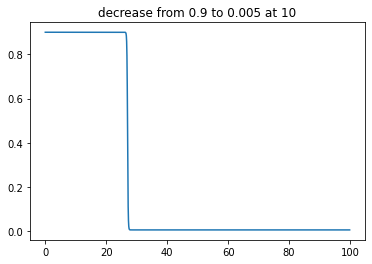

In [3]:

def inverse_sigmoid(x, time_start_decrease):
    e = exp(-steepness_of_change*(x - time_start_decrease))
    return (without_measures - with_measures) * e / (1 + e) + with_measures

t_eval = [x/10 for x in range(1000)]
decrease_eval = [inverse_sigmoid(t, time_measures_implemented) for t in t_eval]

plt.figure()
plt.plot(t_eval, decrease_eval)
plt.title(f"decrease from {without_measures} to {with_measures} at {steepness_of_change}")
plt.show()


In [4]:
thrashing_nfev = 0
thrashings = []

def model_inverse_sigmoid(t, y):
    (S, E, I, R) = y

    global thrashing_nfev
    thrashing_nfev += 1
    thrashings.append( (t, thrashing_nfev) )

    N = 37.741 * (10**6)
    alpha = 1.0/8.0
    beta = inverse_sigmoid(t, time_measures_implemented)
    gamma = 0.06
    mu = 0.01/365

    dSdt = mu*N - mu*S - (beta/N)*I*S
    dEdt = (beta/N)*I*S - alpha*E - mu*E
    dIdt = alpha*E - gamma*I - mu*I
    dRdt = gamma*I - mu*R

    return (dSdt, dEdt, dIdt, dRdt)



In [5]:

def experiment_with_if(method):
    global thrashing_nfev, thrashings
    thrashing_nfev = 0
    thrashings = []

    tspan = [0, 95]
    E0 = 103
    I0 = 1
    R0 = 0
    N = 37.741 * (10**6)
    S0 = N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0)
    t_eval = np.linspace(0, 95, 96)

    start = timer()
    sol = solve_ivp(model_inverse_sigmoid, tspan, y0, method=method, t_eval=t_eval)
    end = timer()

    times_thrashing = [thrashing[0] for thrashing in thrashings]
    nfev_thrashing = [thrashing[1] for thrashing in thrashings]
    plt.plot(times_thrashing, nfev_thrashing, label="nfev")
    plt.xlabel('time')
    plt.ylabel("cumulative nfev")
    plt.title(f"Thrashing without disc hand - {method}")
    plt.legend()
    plt.show()

    return (t_eval, sol.y, sol.nfev, end-start)


In [6]:

def experiment_disc_hand(method):
    global thrashing_nfev, thrashings
    thrashing_nfev = 0
    thrashings = []

    tspan = [0, time_measures_implemented]
    E0 = 103
    I0 = 1
    R0 = 0
    N = 37.741 * (10**6)
    S0 = N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0)
    t_eval = np.linspace(0, time_measures_implemented, time_measures_implemented + 1)

    start1 = timer()
    sol1 = solve_ivp(model_inverse_sigmoid, tspan, y0, t_eval=t_eval, method=method)
    end1 = timer()

    tspan = [time_measures_implemented, 95]
    last_index = len(sol1.y[0]) - 1
    y0 = (sol1.y[0][last_index],
            sol1.y[1][last_index],
            sol1.y[2][last_index],
            sol1.y[3][last_index])
    t_eval = np.linspace(time_measures_implemented, 95, 95-time_measures_implemented+1)
    start2 = timer()
    sol2 = solve_ivp(model_inverse_sigmoid, tspan, y0, t_eval=t_eval, method=method)
    end2 = timer()
    res = (np.concatenate((sol1.t, sol2.t)), 
            np.concatenate((sol1.y, sol2.y), axis=1), 
            sol1.nfev + sol2.nfev, end1-start1 + end2-start2)

    times_thrashing = [thrashing[0] for thrashing in thrashings]
    nfev_thrashing = [thrashing[1] for thrashing in thrashings]
    plt.plot(times_thrashing, nfev_thrashing, label="nfev")
    plt.xlabel('time')
    plt.ylabel("cumulative nfev")
    plt.title(f"Thrashing with disc hand - {method}")
    plt.legend()
    plt.show()
    return res

In [7]:
def high_accuracy():
    tspan = [0, time_measures_implemented]
    E0 = 103
    I0 = 1
    R0 = 0
    N = 37.741 * (10**6)
    S0 = N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0)
    t_eval = np.linspace(0, time_measures_implemented, time_measures_implemented + 1)

    start1 = timer()
    sol1 = solve_ivp(model_inverse_sigmoid, tspan, y0, t_eval=t_eval, atol=1e-12, rtol=1e-12)
    end1 = timer()

    tspan = [time_measures_implemented, 95]
    last_index = len(sol1.y[0]) - 1
    y0 = (sol1.y[0][last_index],
            sol1.y[1][last_index],
            sol1.y[2][last_index],
            sol1.y[3][last_index])
    t_eval = np.linspace(time_measures_implemented, 95, 95-time_measures_implemented+1)
    start2 = timer()
    sol2 = solve_ivp(model_inverse_sigmoid, tspan, y0, t_eval=t_eval, atol=1e-12, rtol=1e-12)
    end2 = timer()
    res = (np.concatenate((sol1.t, sol2.t)), 
            np.concatenate((sol1.y, sol2.y), axis=1), 
            sol1.nfev + sol2.nfev, end1-start1 + end2-start2)
    return res
(times_high, res_high, nfev_high, elapsed_high) = high_accuracy()

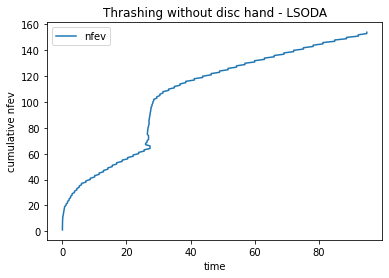

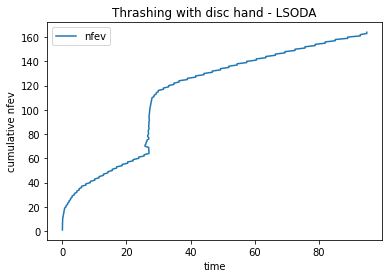

In [8]:
(times_lsoda_if, res_lsoda_if, nfev_lsoda_if, elapsed_lsoda_if) = experiment_with_if('LSODA')
(times_lsoda, res_lsoda, nfev_lsoda, elapsed_lsoda) = experiment_disc_hand("LSODA")


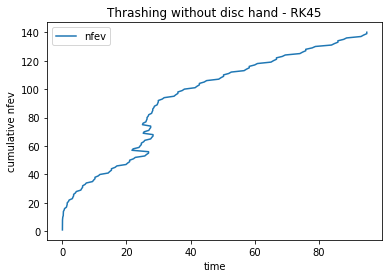

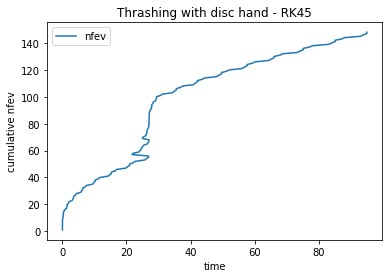

In [9]:
(times_rk45_if, res_rk45_if, nfev_rk45_if, elapsed_rk45_if) = experiment_with_if('RK45')
(times_rk45, res_rk45, nfev_rk45, elapsed_rk45) = experiment_disc_hand("RK45")

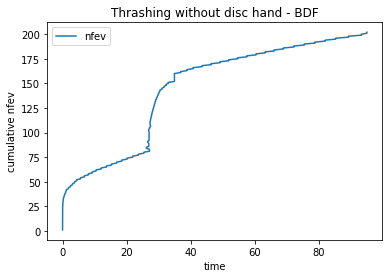

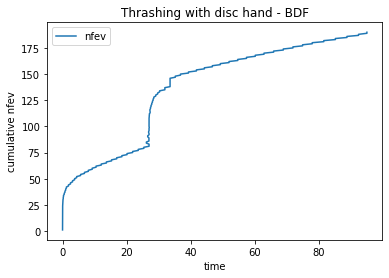

In [10]:
(times_bdf_if, res_bdf_if, nfev_bdf_if, elapsed_bdf_if) = experiment_with_if('BDF')
(times_bdf, res_bdf, nfev_bdf, elapsed_bdf) = experiment_disc_hand("BDF")


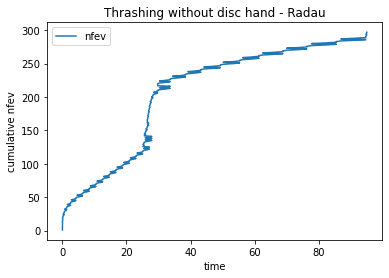

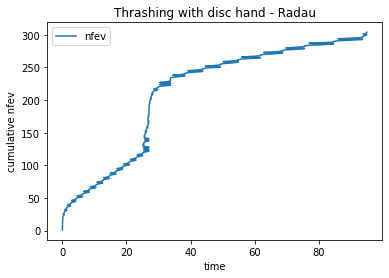

In [11]:
(times_radau_if, res_radau_if, nfev_radau_if, elapsed_radau_if) = experiment_with_if('Radau')
(times_radau, res_radau, nfev_radau, elapsed_radau) = experiment_disc_hand("Radau")

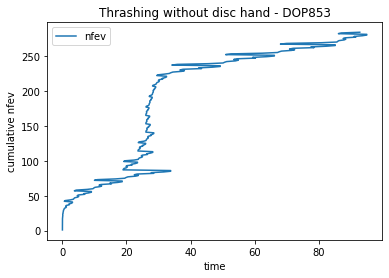

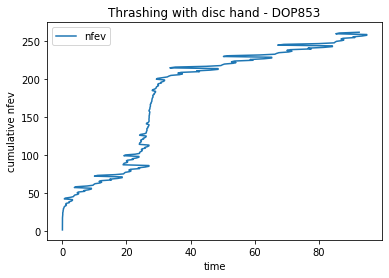

In [12]:
(times_dop853_if, res_dop853_if, nfev_dop853_if, elapsed_dop853_if) = experiment_with_if('DOP853')
(times_dop853, res_dop853, nfev_dop853, elapsed_dop853) = experiment_disc_hand("DOP853")


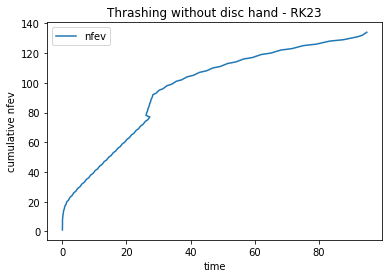

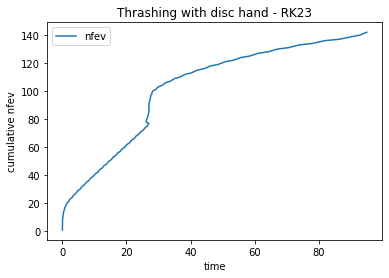

In [13]:
(times_rk23_if, res_rk23_if, nfev_rk23_if, elapsed_rk23_if) = experiment_with_if('RK23')
(times_rk23, res_rk23, nfev_rk23, elapsed_rk23) = experiment_disc_hand("RK23")

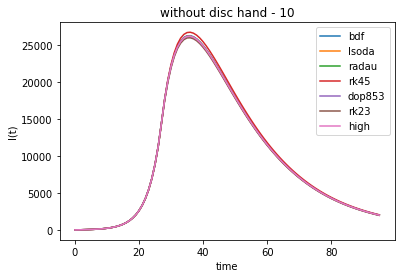

lsoda & 154 & 0.010440099999982522 \\
rk45 & 140 & 0.011376900000016121 \\
bdf & 186 & 0.04597110000003113 \\
radau & 288 & 0.03737530000000788 \\
dop853 & 284 & 0.013690999999994347 \\
rk23 & 134 & 0.021080499999982294 \\
high & 5782 & 0.19637360000001536 \\


In [14]:
plt.plot(times_bdf_if    , res_bdf_if[2], label="bdf")
plt.plot(times_lsoda_if  , res_lsoda_if[2], label="lsoda")
plt.plot(times_radau_if  , res_radau_if[2], label="radau")
plt.plot(times_rk45_if   , res_rk45_if[2], label="rk45")
plt.plot(times_dop853_if , res_dop853_if[2], label="dop853")
plt.plot(times_rk23_if   , res_rk23_if[2], label="rk23")
plt.plot(times_high      , res_high[2], label="high")
plt.xlabel('time')
plt.ylabel("I(t)")
plt.title(f"without disc hand - {steepness_of_change}")
plt.legend()
plt.show()

print(f"lsoda & {nfev_lsoda_if} & {elapsed_lsoda_if} \\\\")
print(f"rk45 & {nfev_rk45_if} & {elapsed_rk45_if} \\\\")
print(f"bdf & {nfev_bdf_if} & {elapsed_bdf_if} \\\\")
print(f"radau & {nfev_radau_if} & {elapsed_radau_if} \\\\")
print(f"dop853 & {nfev_dop853_if} & {elapsed_dop853_if} \\\\")
print(f"rk23 & {nfev_rk23_if} & {elapsed_rk23_if} \\\\")
print(f"high & {nfev_high} & {elapsed_high} \\\\")


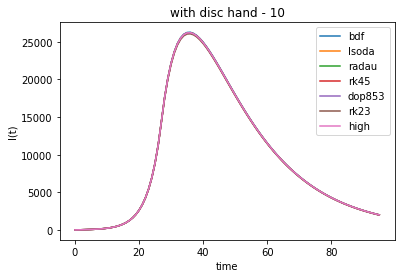

lsoda & 164 & 0.007754999999974643 \\
rk45 & 148 & 0.01146640000001753 \\
bdf & 174 & 0.03351199999997334 \\
radau & 287 & 0.04171110000004319 \\
dop853 & 262 & 0.010366499999975076 \\
rk23 & 142 & 0.01374169999996866 \\
high & 5782 & 0.19637360000001536 \\


In [15]:
plt.plot(times_bdf    , res_bdf[2], label="bdf")
plt.plot(times_lsoda  , res_lsoda[2], label="lsoda")
plt.plot(times_radau  , res_radau[2], label="radau")
plt.plot(times_rk45   , res_rk45[2], label="rk45")
plt.plot(times_dop853 , res_dop853[2], label="dop853")
plt.plot(times_rk23   , res_rk23[2], label="rk23")
plt.plot(times_high   , res_high[2], label="high")
plt.xlabel('time')
plt.ylabel("I(t)")
plt.title(f"with disc hand - {steepness_of_change}")
plt.legend()
plt.show()

print(f"lsoda & {nfev_lsoda} & {elapsed_lsoda} \\\\")
print(f"rk45 & {nfev_rk45} & {elapsed_rk45} \\\\")
print(f"bdf & {nfev_bdf} & {elapsed_bdf} \\\\")
print(f"radau & {nfev_radau} & {elapsed_radau} \\\\")
print(f"dop853 & {nfev_dop853} & {elapsed_dop853} \\\\")
print(f"rk23 & {nfev_rk23} & {elapsed_rk23} \\\\")
print(f"high & {nfev_high} & {elapsed_high} \\\\")